# Mock power dataset testing

In [1]:
from radiocalibrationtoolkit import *

[INFO] LFmap: Import successful.


In [2]:
# some global plot settings
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["font.weight"] = "bold"
plt.rcParams["font.size"] = 16
plt.rcParams["legend.fontsize"] = 14

plt.rcParams["xtick.major.width"] = 2
plt.rcParams["ytick.major.width"] = 2

plt.rcParams["xtick.major.size"] = 5
plt.rcParams["ytick.major.size"] = 5

plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["ytick.labelsize"] = 14

In [3]:
# This ensures Plotly output works in multiple places:
# plotly_mimetype: VS Code notebook UI
# notebook: "Jupyter: Export to HTML" command in VS Code
# See https://plotly.com/python/renderers/#multiple-renderers
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook"

In [4]:
def dataset_test(
    power_rec_file="", power_sim_file="", hw_file="", temp_celsius=30, additional_noise=0
):
    power_sim_DF = pd.read_csv(power_sim_file, index_col=0)
    power_sim_DF.columns = power_sim_DF.columns.astype(float)
    power_sim_DF.iloc[:, :] = power_sim_DF.values

    power_rec_DF = pd.read_csv(power_rec_file, index_col=0)
    power_rec_DF.columns = power_rec_DF.columns.astype(float)
    power_rec_DF.iloc[:, :] = power_rec_DF.values
    power_rec_DF = power_rec_DF.loc[:, power_sim_DF.columns]

    hw_dict = read_hw_file(hw_file, interp_args={"fill_value": "extrapolate"})
    hw_reponse_1 = hw_dict["RResponse"]["LNA"]
    hw_reponse_2 = hw_dict["RResponse"]["digitizer"]
    hw_reponse_3 = hw_dict["RResponse"]["cable_fromLNA2digitizer"]
    hw_reponse_4 = hw_dict["RResponse"]["impedance_matching_EW"]

    # merge all hw responses to one function
    def hw_response_func(x):
        return dB2PowerAmp(
            hw_reponse_1(x) + hw_reponse_2(x) + hw_reponse_3(x) + hw_reponse_4(x)
        )

    # impedance function
    impedance_func = hw_dict["IImpedance"]["antenna_EW"]

    ###

    temp_celsius = temp_celsius
    frequencies_MHz = np.linspace(30, 80, 51)
    temperature_noise = (
        4
        * constants.Boltzmann
        * (temp_celsius + 273.15)
        * impedance_func(frequencies_MHz)
    )
    hw_amplification = hw_response_func(frequencies_MHz)
    impedance = impedance_func(frequencies_MHz)
    additional_noise = additional_noise / impedance
    q = temperature_noise * hw_amplification / impedance * 1e12 + additional_noise

    q = integrate_spectral_density(
        pd.DataFrame([q], columns=frequencies_MHz),
        integrated_MHz_bands=np.linspace(30, 80, 51),
        integrating_method="on_discontinuous_function",
    )
    frequencies_MHz = power_rec_DF.columns.values

    q = q.values.flatten()

    ###
    fig, ax = plt.subplots()
    ax.plot(
        power_sim_DF.columns.values, (power_sim_DF.mean().values + q)[:], label="sim"
    )
    ax.plot(
        power_rec_DF.columns.values, (power_rec_DF.mean().values)[:], label="rec (mock)"
    )
    ax.legend()
    ax.set_xlabel("frequency [MHz]")
    ax.set_ylabel("power [pW]")

    fig, ax = plt.subplots()
    ax.plot(
        power_sim_DF.columns.values,
        (power_sim_DF.mean().values + q) / (power_rec_DF.mean().values) - 1,
    )
    ax.set_xlabel("frequency [MHz]")
    ax.set_ylabel("(sim+TN)/mock - 1")

    fig = px.imshow(
        power_rec_DF.T / (power_sim_DF + q).values.T - 1,
        width=600,
        aspect="cube",
        color_continuous_scale="jet",
    )
    fig.update_layout(
    xaxis=dict(title="<b>LST</b>", tickprefix="<b>", ticksuffix="</b>", dtick=2),
    yaxis=dict(
        title="<b>frequency [MHz]</b>",
        tickprefix="<b>",
        ticksuffix="</b>",
        range=(30, 80),
        tick0=0,
        dtick=10,
        autorange=False,
    ),
    coloraxis=dict(
        colorbar=dict(
            title=dict(
                text="<b>(sim+TN)/mock - 1</b>",
                side="right",
            ),
            tickprefix="<b>",
            ticksuffix="</b>",
        ),
    ),
    font=dict(
        # family=font,
        size=20,
        color="black",
    ),
    )
    fig.show()

In [5]:
power_rec_file_ideal_list = [
    "./mock_power_datasets/mock_power_dataset-isoAnt_GSM16_N10000_temp30.0C_0.0additionalnoise_rounding-False.csv",
    "./mock_power_datasets/mock_power_dataset-isoAnt_GSM16_N10000_temp30.0C_5e-16additionalnoise_rounding-False.csv",
    "./mock_power_datasets/mock_power_dataset-isoAnt_GSM16_N10000_temp30.0C_0.0additionalnoise_rounding-True.csv"
]

power_rec_file_real_list = [
    "./mock_power_datasets/mock_power_dataset-Salla_EW_GSM16_N10000_temp30.0C_0.0additionalnoise_rounding-False.csv",
    "./mock_power_datasets/mock_power_dataset-Salla_EW_GSM16_N10000_temp30.0C_0.0additionalnoise_rounding-True.csv",
]

power_sim_ideal = './simulated_power_datasets/isoAnt_flathw_GSM16.csv'
power_sim_real =  './simulated_power_datasets/Salla_EW_GSM16.csv' 

# read HW response
hw_file_ideal = "./antenna_setup_files/HardwareProfileList_flat.xml"
hw_file_real = "./antenna_setup_files/HardwareProfileList_realistic.xml"


temp_celsius = 30
an = 5e-4



## Isotropic antenna gain, flat HW response, no rounding, no extra noise

<Element HardwareProfileList at 0x7f82da5bbcc0>


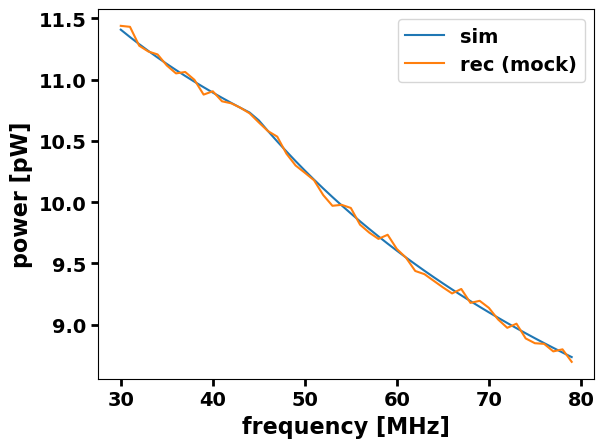

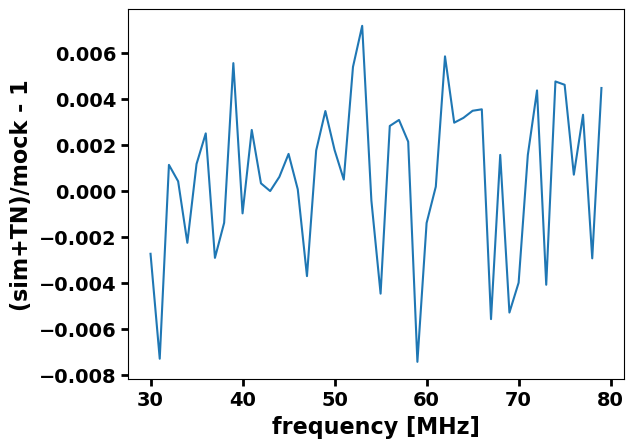

In [6]:
dataset_test(power_rec_file=power_rec_file_ideal_list[0], power_sim_file=power_sim_ideal, hw_file=hw_file_ideal, temp_celsius=30, additional_noise=0)

## Isotropic antenna gain, flat HW response, no rounding, extra noise

<Element HardwareProfileList at 0x7f82d8118c40>


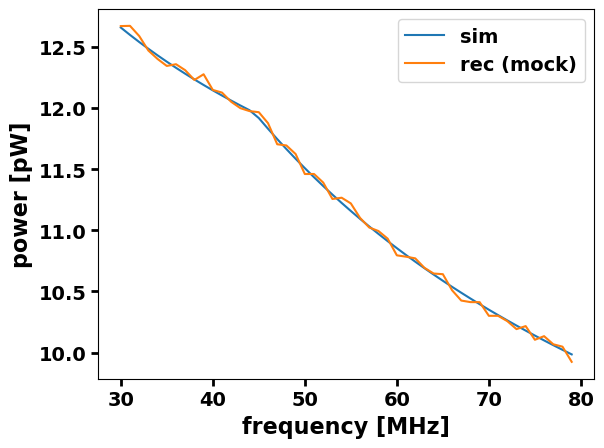

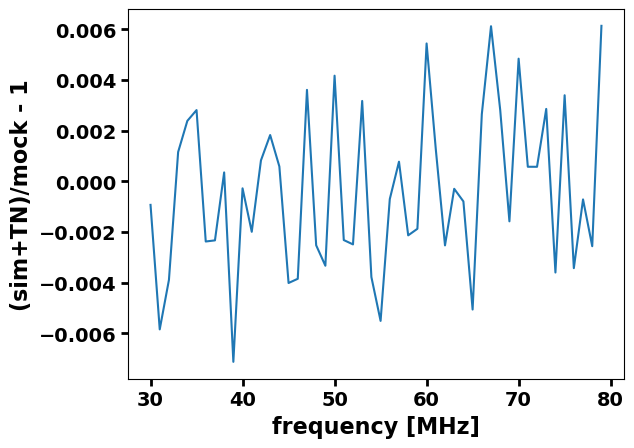

In [7]:
dataset_test(power_rec_file=power_rec_file_ideal_list[1], power_sim_file=power_sim_ideal, hw_file=hw_file_ideal, temp_celsius=30, additional_noise=an)

## Isotropic antenna gain, flat HW response, rounded, no extra noise

<Element HardwareProfileList at 0x7f82d65a1500>


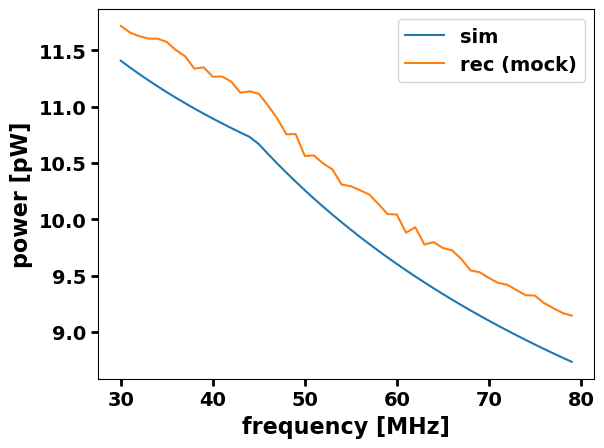

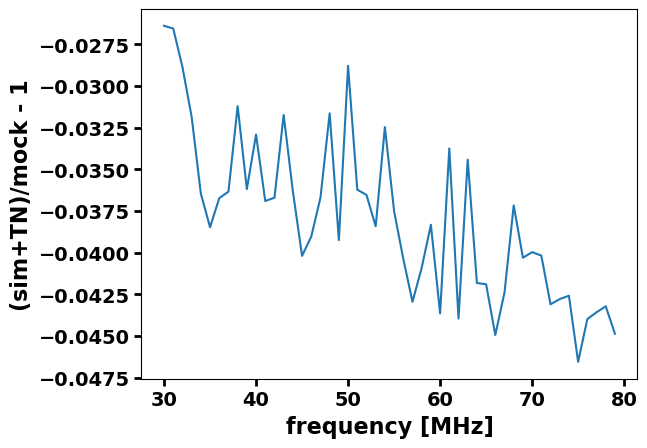

In [8]:
dataset_test(power_rec_file=power_rec_file_ideal_list[2], power_sim_file=power_sim_ideal, hw_file=hw_file_ideal, temp_celsius=30, additional_noise=0)

## Realistic antenna gain and HW response, no rounding, no extra noise

<?xml version="1.0" encoding="iso-8859-1"?>
<Element HardwareProfileList at 0x7f82d6137ac0>


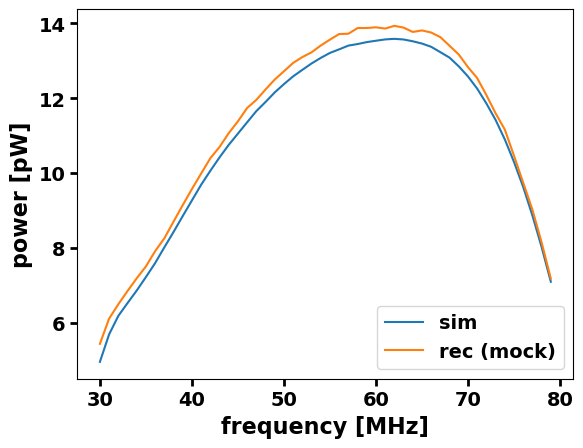

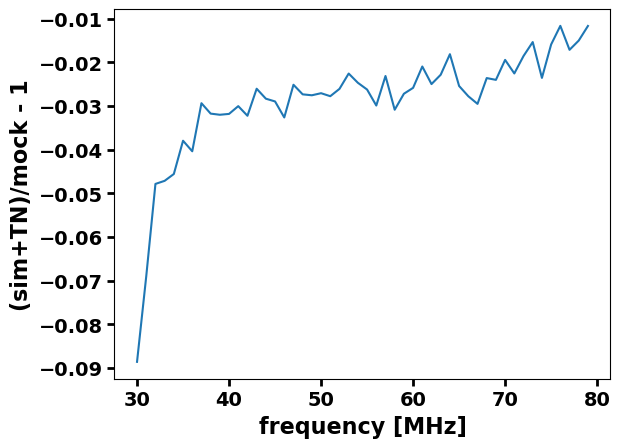

In [9]:
dataset_test(power_rec_file=power_rec_file_real_list[1], power_sim_file=power_sim_real, hw_file=hw_file_real, temp_celsius=30, additional_noise=0)

## Realistic antenna gain and HW response, rounded, no extra noise

<?xml version="1.0" encoding="iso-8859-1"?>
<Element HardwareProfileList at 0x7f82d5d57500>


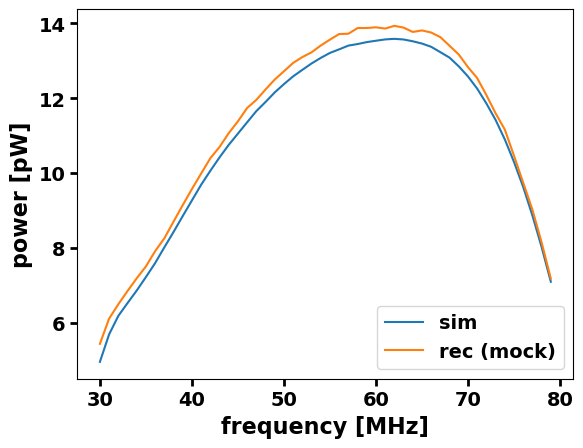

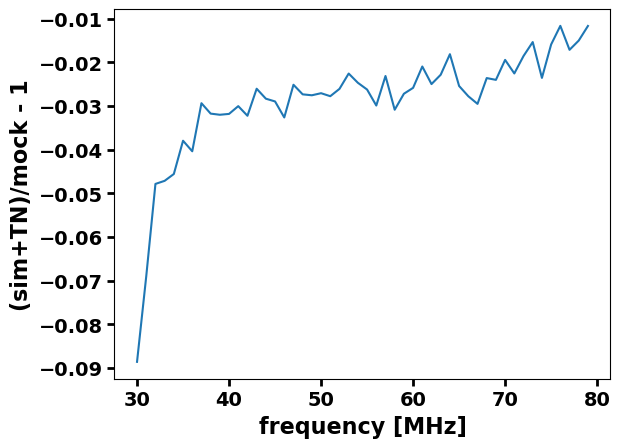

In [10]:
dataset_test(power_rec_file=power_rec_file_real_list[1], power_sim_file=power_sim_real, hw_file=hw_file_real, temp_celsius=30, additional_noise=0)